In [82]:
#!pip install lightgbm
#!pip install category_encoders

# Import libraries

In [3]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sp
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import time
from numpy import nan
from numpy import inf
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_classif,SelectKBest, f_classif
from sklearn.metrics import classification_report,accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, QuantileTransformer, RobustScaler
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import loguniform
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from category_encoders.hashing import HashingEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

# Part I (Static Model):

## Data Analysis

### Imported dataSet

In [2]:
datasetStatic= pd.read_csv("./Static_dataset.csv")
datasetStatic

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,56:19.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,07:23.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,23:15.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,04:51.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,12:44.0,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268069,33:51.5,18,3,0,16,0,2.338623,2,3,10,5.333333,alma,almaalomah,14,1,0
268070,36:02.5,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,0
268071,37:21.5,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
268072,24:25.1,16,0,0,14,0,3.249687,2,2,13,7.500000,radio,radio-vintage,14,0,0


#### validating if your dataset is imbalanced

In [3]:
def show_data_balanceing(title, lst_names, lst_cls ):
  plt.bar(lst_names,lst_cls,width=0.3)
  plt.title(title)
  plt.xlabel('classes')
  plt.xticks(ha='right')
  plt.ylabel('frequenncy')
  plt.show()

In [4]:
# validate if your dataset is imbalanced 
datasetStatic['Target Attack'].value_counts()

1    147179
0    120895
Name: Target Attack, dtype: int64

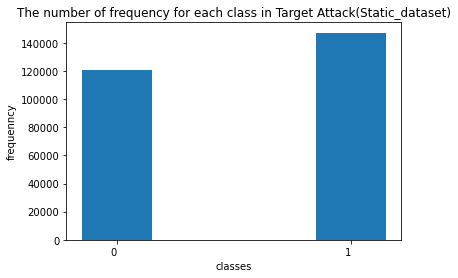

In [5]:
count_0 = datasetStatic['Target Attack'].value_counts()[0]
count_1 = datasetStatic['Target Attack'].value_counts()[1]
show_data_balanceing("The number of frequency for each class in Target Attack(Static_dataset)", ['0','1'], [count_0, count_1])

#### using plots and statistical tools the distribution of each feature and the target variable.

In [239]:
datasetStatic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268074 non-null  object 
 1   FQDN_count        268074 non-null  int64  
 2   subdomain_length  268074 non-null  int64  
 3   upper             268074 non-null  int64  
 4   lower             268074 non-null  int64  
 5   numeric           268074 non-null  int64  
 6   entropy           268074 non-null  float64
 7   special           268074 non-null  int64  
 8   labels            268074 non-null  int64  
 9   labels_max        268074 non-null  int64  
 10  labels_average    268074 non-null  float64
 11  longest_word      268066 non-null  object 
 12  sld               268074 non-null  object 
 13  len               268074 non-null  int64  
 14  subdomain         268074 non-null  int64  
 15  Target Attack     268074 non-null  int64  
dtypes: float64(2), int64

In [240]:
datasetStaticOnlynumeric = datasetStatic.select_dtypes(include=['int64','float64'])
datasetStaticOnlynumeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   FQDN_count        268074 non-null  int64  
 1   subdomain_length  268074 non-null  int64  
 2   upper             268074 non-null  int64  
 3   lower             268074 non-null  int64  
 4   numeric           268074 non-null  int64  
 5   entropy           268074 non-null  float64
 6   special           268074 non-null  int64  
 7   labels            268074 non-null  int64  
 8   labels_max        268074 non-null  int64  
 9   labels_average    268074 non-null  float64
 10  len               268074 non-null  int64  
 11  subdomain         268074 non-null  int64  
 12  Target Attack     268074 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 26.6 MB


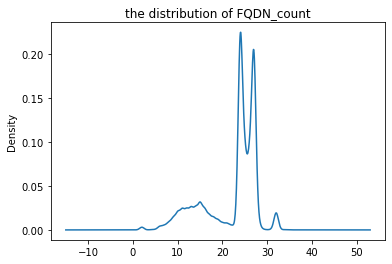

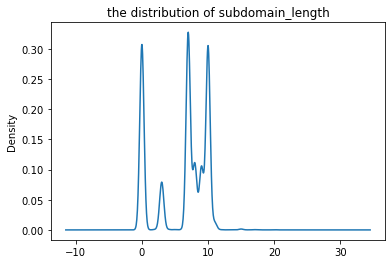

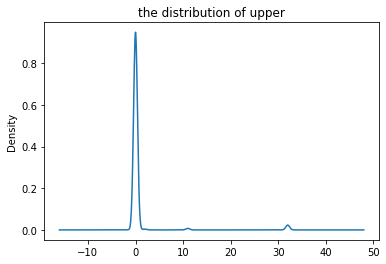

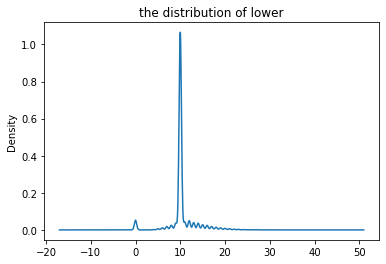

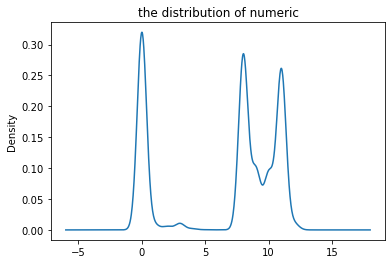

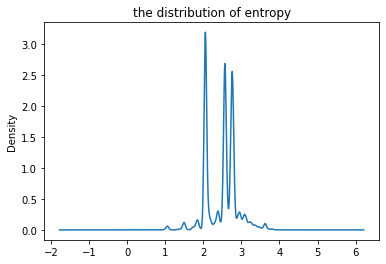

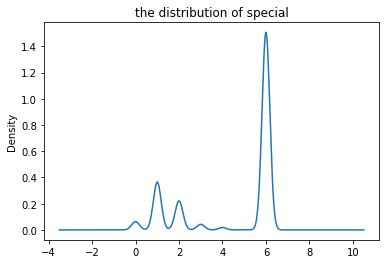

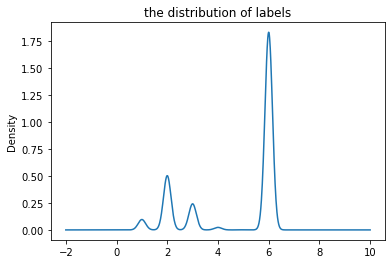

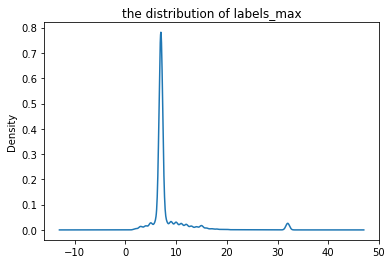

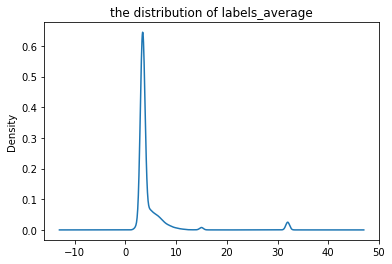

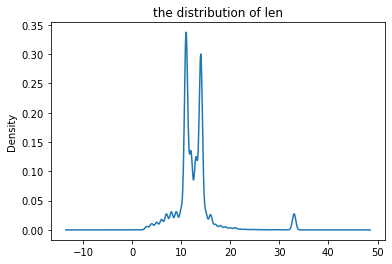

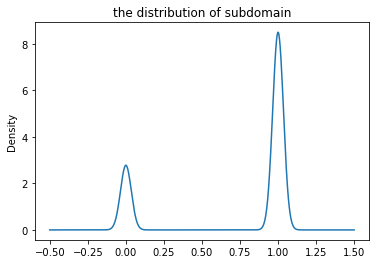

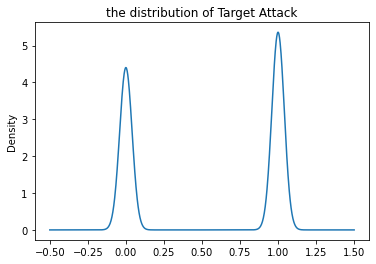

In [54]:
# Plot the distribution of each feature and the target variable,
for f in datasetStaticOnlynumeric.columns:
    datasetStaticOnlynumeric[f].plot.kde()
    plt.title(f"the distribution of {f}")
    plt.show()

## Feature engineering and data cleaning

In [71]:
#datasetStatic['timestamp'].dtypes

In [43]:
# remove timestamp column
datasetStaticWithoutTime = datasetStatic.iloc[:,1:]
datasetStaticWithoutTime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   FQDN_count        268074 non-null  int64  
 1   subdomain_length  268074 non-null  int64  
 2   upper             268074 non-null  int64  
 3   lower             268074 non-null  int64  
 4   numeric           268074 non-null  int64  
 5   entropy           268074 non-null  float64
 6   special           268074 non-null  int64  
 7   labels            268074 non-null  int64  
 8   labels_max        268074 non-null  int64  
 9   labels_average    268074 non-null  float64
 10  longest_word      268066 non-null  object 
 11  sld               268074 non-null  object 
 12  len               268074 non-null  int64  
 13  subdomain         268074 non-null  int64  
 14  Target Attack     268074 non-null  int64  
dtypes: float64(2), int64(11), object(2)
memory usage: 30.7+ MB


In [44]:
datasetStaticWithoutTime.isnull().sum()

FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        8
sld                 0
len                 0
subdomain           0
Target Attack       0
dtype: int64

In [45]:
# show information for Cloumns that have problems.
datasetStaticWithoutTime.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   longest_word  268066 non-null  object
 1   sld           268074 non-null  object
dtypes: object(2)
memory usage: 4.1+ MB


In [46]:
datasetStaticWithoutTime["longest_word"].value_counts()

2          109981
4           70188
N            4498
C            2969
9            1906
            ...  
yaa             1
queue           1
kit             1
airdrop         1
mal             1
Name: longest_word, Length: 6224, dtype: int64

In [47]:
datasetStaticWithoutTime['longest_word'] = datasetStaticWithoutTime['longest_word'].astype('str')
datasetStaticWithoutTime['longest_word'] = datasetStaticWithoutTime['longest_word'].apply(lambda x: x if any(c.isnumeric() for c in x) else len(x)).astype('int')

In [48]:
datasetStaticWithoutTime['longest_word'].value_counts()

2     117771
4      86053
5      14100
3      13894
1      11525
6       8723
7       6511
9       4202
8       3556
10      1033
11       427
12       117
13        71
0         56
14        24
15         6
16         5
Name: longest_word, dtype: int64

In [49]:
datasetStaticWithoutTime['sld'].value_counts()

192                                 109517
224                                  70188
FHEPFCELEHFCEPFFFACACACACACACABN      4498
DESKTOP-3JF04TC                       1961
239                                   1906
                                     ...  
freesgift                                1
secureserver                             1
airdropalert                             1
queue-it                                 1
lahemal                                  1
Name: sld, Length: 11112, dtype: int64

In [50]:
modeSld = datasetStaticWithoutTime['sld'].mode()[0]
datasetStaticWithoutTime['sld'] = datasetStaticWithoutTime['sld'].replace(r'(([a-z]+)|([A-Z]+|(0-1)))',70, regex=True).astype('int')

In [51]:
datasetStaticWithoutTime['sld'].value_counts()

192       109517
70         85972
224        70188
239         1906
172          424
573            8
352            8
72             8
1242           8
365838         8
981            8
32877          8
13             7
911            4
Name: sld, dtype: int64

<AxesSubplot:title={'center':'the distribution of longest_word After cleaning it:'}, ylabel='Density'>

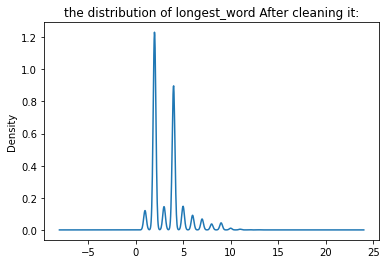

In [52]:
plt.title("the distribution of longest_word After cleaning it:")
datasetStaticWithoutTime["longest_word"].plot.kde()

In [71]:
# Show information the features of "Static_dataset.csv" after cleaning
datasetStaticWithoutTime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   FQDN_count        268074 non-null  int64  
 1   subdomain_length  268074 non-null  int64  
 2   upper             268074 non-null  int64  
 3   lower             268074 non-null  int64  
 4   numeric           268074 non-null  int64  
 5   entropy           268074 non-null  float64
 6   special           268074 non-null  int64  
 7   labels            268074 non-null  int64  
 8   labels_max        268074 non-null  int64  
 9   labels_average    268074 non-null  float64
 10  longest_word      268074 non-null  int32  
 11  sld               268074 non-null  int32  
 12  len               268074 non-null  int64  
 13  subdomain         268074 non-null  int64  
 14  Target Attack     268074 non-null  int64  
dtypes: float64(2), int32(2), int64(11)
memory usage: 28.6 MB


In [54]:
# Show the number of null values in data 
datasetStaticWithoutTime.isnull().sum()

FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        0
sld                 0
len                 0
subdomain           0
Target Attack       0
dtype: int64

Get outliers in each feature.

In [17]:
# calculate IQR for data Set (datasetStaticWithoutTime)
IQR1_train = datasetStaticWithoutTime.quantile(0.25)
IQR3_train = datasetStaticWithoutTime.quantile(0.75)
IQR_train = IQR3_train - IQR1_train
print("Number of possible outliers per feature")
print(((datasetStaticWithoutTime < (IQR1_train - 1.5 * IQR_train)) | (datasetStaticWithoutTime > (IQR3_train + 1.5 * IQR_train))).sum())

Number of possible outliers per feature
FQDN_count           1084
Target Attack           0
entropy               164
labels                  0
labels_average      48373
labels_max          77958
len                 21267
longest_word            0
lower               78793
numeric                 0
sld                    75
special                 0
subdomain           66081
subdomain_length       14
upper                9315
dtype: int64


C:\Users\AhmedPro\AppData\Local\Temp\ipykernel_12204\198454502.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  print(((datasetStaticWithoutTime < (IQR1_train - 1.5 * IQR_train)) | (datasetStaticWithoutTime > (IQR3_train + 1.5 * IQR_train))).sum())


## Feature Filtering/Selection:

In [21]:
# import seaborn as sb
# plt.figure(figsize=(10,8))
# sb.heatmap(datasetStaticWithoutTime.corr(), cmap="YlGnBu", annot=True)

In [22]:
#sns.pairplot(datasetStaticWithoutTime, hue="Target Attack")

In [76]:
X = datasetStaticWithoutTime.drop(labels = ["Target Attack"], axis=1)
y = datasetStaticWithoutTime["Target Attack"]
print(f"The shape of datasetStaticWithoutTime: {datasetStaticWithoutTime.shape}")
print(f"The shape of X: {X.shape}")
print(f"The shape of y: {y.shape}")

The shape of datasetStaticWithoutTime: (268074, 15)
The shape of X: (268074, 14)
The shape of y: (268074,)


In [77]:
X

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain
0,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1
1,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1
2,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1
3,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1
4,15,9,0,11,0,2.929439,4,3,5,4.333333,5,70,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268069,18,3,0,16,0,2.338623,2,3,10,5.333333,4,70,14,1
268070,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1
268071,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1
268072,16,0,0,14,0,3.249687,2,2,13,7.500000,5,70,14,0


In [92]:
# determine the mutual information
def detectImportanceBymutual_info_classif(Title,X,y):
  mutual_info = mutual_info_classif(X, y)
  mutual_info = pd.Series(mutual_info)
  mutual_info.index = X.columns
  #print(mutual_info.sort_values(ascending=False))
  plt.title("Degree of features in importance of "+Title)
  mutual_info.sort_values(ascending=False).plot.barh(figsize=(20, 8))
  listIMp = []
  for i,v in enumerate(mutual_info):
    if v > 0.05:
      listIMp.append(i)
  X_imp = X.copy().iloc[:, listIMp]
  return X_imp

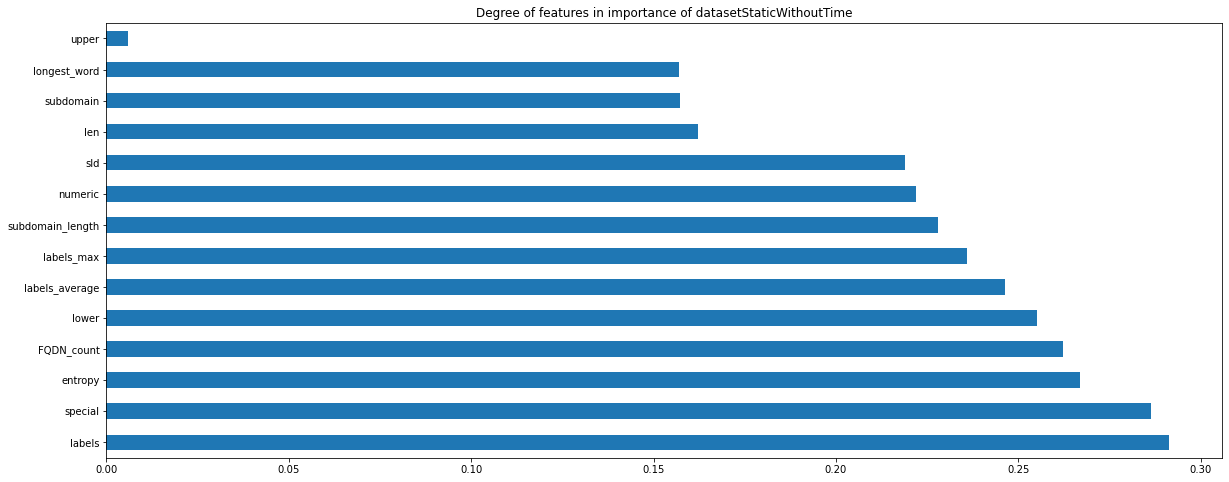

In [93]:
X_imp = detectImportanceBymutual_info_classif("datasetStaticWithoutTime",X, y)

In [22]:
X_imp.shape

(268074, 13)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [98]:
numFeatures = X.shape[1]

In [99]:
# appling modeling in pipline
def ApplyMode(Model, X_train, y_train, X_val, y_val):
    Model.fit(X_train, y_train)  # apply scaling on training data
    #acc = pipe.score(X_test, y_test)
    y_pred=Model.predict(X_val)
    Recall = recall_score(y_val, y_pred, pos_label=1) #classification_report(y_pred,y_val, output_dict=True)['1']['recall']
    #print(classification_report(y_pred,y_val))
    #print(classification_report(y_pred,y_test))
    print(f'The Recall score (Class 1) : {Recall}')
    return Model, Recall

### ANOVA

In [47]:
listTestAcc_ANOVA_LR = []
listTestAcc_ANOVA_LGBM = []
for f in range(2,numFeatures+1):
    # configure to select all features
    ANOVAfs = SelectKBest(score_func=f_classif, k=f)
    X_train_AfterANOVA = ANOVAfs.fit_transform(X_train, y_train)
    X_val_AfterANOVA = ANOVAfs.transform(X_val)
    print(f"Training by {f} component on LogisticRegression After using ANOVA to:")
    _, testval = ApplyMode(LogisticRegression(max_iter=1000), X_train_AfterANOVA, y_train, X_val_AfterANOVA, y_val)
    listTestAcc_ANOVA_LR.append(testval)
    print(f"Training by {f} component on LGBMClassifier After using ANOVA to:")
    _, testvalL = ApplyMode(LGBMClassifier(random_state=42),X_train_AfterANOVA, y_train, X_val_AfterANOVA, y_val)
    listTestAcc_ANOVA_LGBM.append(testvalL)
    print('-------------------------------------------------------------------------------------------------------------------------')

Training by 2 component on LogisticRegression After using ANOVA to:
The Recall score (Class 1) : 0.9391136409839398
Training by 2 component on LGBMClassifier After using ANOVA to:
The Recall score (Class 1) : 0.9985769465338483
-------------------------------------------------------------------------------------------------------------------------
Training by 3 component on LogisticRegression After using ANOVA to:
The Recall score (Class 1) : 0.9391136409839398
Training by 3 component on LGBMClassifier After using ANOVA to:
The Recall score (Class 1) : 0.9987124754353865
-------------------------------------------------------------------------------------------------------------------------
Training by 4 component on LogisticRegression After using ANOVA to:
The Recall score (Class 1) : 0.9401639899708613
Training by 4 component on LGBMClassifier After using ANOVA to:
The Recall score (Class 1) : 0.9987124754353865
------------------------------------------------------------------------

In [49]:
# LogisticRegression (The Recall score (Class 1))
Df_listTestAcc_ANOVA_LR = pd.DataFrame({'The Recall score (Class 1) of LR with ANOVA':listTestAcc_ANOVA_LR},index = range(2,numFeatures+1))
Df_listTestAcc_ANOVA_LR

,The Recall score (Class 1) of LR with ANOVA
2,0.939114
3,0.939114
4,0.940164
5,0.940164
6,0.940164
7,0.972217
8,0.990818
9,0.995968
10,0.990818
11,0.996002


In [50]:
# LGBMClassifier (The Recall score (Class 1))
Df_listTestAcc_ANOVA_LGBM = pd.DataFrame({'The Recall score (Class 1) of LGBM with ANOVA':listTestAcc_ANOVA_LGBM},index = range(2,numFeatures+1))
Df_listTestAcc_ANOVA_LGBM

,The Recall score (Class 1) of LGBM with ANOVA
2,0.998577
3,0.998712
4,0.998712
5,0.999119
6,0.999119
7,0.999255
8,0.999221
9,0.999797
10,0.999797
11,0.999763


In [11]:
len(range(2, 14))

12

In [51]:
print(f'{Df_listTestAcc_ANOVA_LR.idxmax()[0]} components is the best value based on The Recall score (Class 1) of the LogisticRegression classifier with ANOVA: {Df_listTestAcc_ANOVA_LR.max()[0]}%')
print(f'{Df_listTestAcc_ANOVA_LGBM.idxmax()[0]} components is the best value based on The Recall score (Class 1) of the LGBMClassifier classifier with ANOVA: {Df_listTestAcc_ANOVA_LGBM.max()[0]}%')

11 components is the best value based on The Recall score (Class 1) of the LogisticRegression classifier with ANOVA: 0.9960018974046215%
9 components is the best value based on The Recall score (Class 1) of the LGBMClassifier classifier with ANOVA: 0.9997967066476926%


### PCA

In [52]:
print(f'The number of features: {numFeatures}')
listTestAccLR = []
listTestAccLGBM = []
for f in range(2,numFeatures+1):
    pca = PCA(n_components=f, random_state=0)
    X_train_AfterPCA = pca.fit_transform(X_train)
    X_val_AfterPCA = pca.transform(X_val)
    print(f"Training by {f} component on LogisticRegression After using PCA to:")
    _, valAcc = ApplyMode(LogisticRegression(max_iter=1000, C=10), X_train_AfterPCA, y_train, X_val_AfterPCA, y_val)
    listTestAccLR.append(valAcc)
    print(f"Training by {f} component on LGBMClassifier After using PCA to:")
    _, valAccL = ApplyMode(LGBMClassifier(random_state=42),X_train_AfterPCA, y_train, X_val_AfterPCA, y_val)
    listTestAccLGBM.append(valAccL)
    print('-------------------------------------------------------------------------------------------------------------------------')

The number of features: 14
Training by 2 component on LogisticRegression After using PCA to:
The Recall score (Class 1) : 0.9554787558446839
Training by 2 component on LGBMClassifier After using PCA to:
The Recall score (Class 1) : 0.9995595310700007
-------------------------------------------------------------------------------------------------------------------------
Training by 3 component on LogisticRegression After using PCA to:
The Recall score (Class 1) : 0.9735718642000406
Training by 3 component on LGBMClassifier After using PCA to:
The Recall score (Class 1) : 0.9995934132953852
-------------------------------------------------------------------------------------------------------------------------
Training by 4 component on LogisticRegression After using PCA to:
The Recall score (Class 1) : 0.9824490072507962
Training by 4 component on LGBMClassifier After using PCA to:
The Recall score (Class 1) : 0.9997967066476926
---------------------------------------------------------

In [53]:
# LogisticRegression (The Recall score)
Df_listTestAccLR = pd.DataFrame({"The Recall score (Class 1) of LR with PCA":listTestAccLR},index = range(2,numFeatures+1))
Df_listTestAccLR

,The Recall score (Class 1) of LR with PCA
2,0.955479
3,0.973572
4,0.982449
5,0.982449
6,0.977367
7,0.977367
8,0.995968
9,0.990818
10,0.990818
11,0.996002


In [54]:
# LGBMClassifier (The Recall score)
Df_listTestAccLGBM = pd.DataFrame({"The Recall score (Class 1) of LGBM with PCA":listTestAccLGBM},index = range(2,numFeatures+1))
Df_listTestAccLGBM

,The Recall score (Class 1) of LGBM with PCA
2,0.999560
3,0.999593
4,0.999797
5,0.999763
6,0.999763
7,0.999797
8,0.992343
9,0.999797
10,0.989225
11,0.992309


In [55]:
print(f'{Df_listTestAccLR.idxmax()[0]} components is the best value based on the Recall score (Class 1) of the LogisticRegression classifier with PCA: {Df_listTestAccLR.max()[0]}%')
print(f'{Df_listTestAccLGBM.idxmax()[0]} components is the best value based on the Recall score (Class 1) of the LGBMClassifier classifier with PCA: {Df_listTestAccLGBM.max()[0]}%')

11 components is the best value based on the Recall score (Class 1) of the LogisticRegression classifier with PCA: 0.9960018974046215%
4 components is the best value based on the Recall score (Class 1) of the LGBMClassifier classifier with PCA: 0.9997967066476926%


 ###### plot the performace of both models With ANOVA and PCA

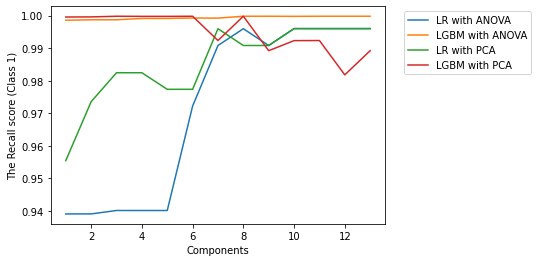

In [17]:
plt.plot(range(1, 14),listTestAcc_ANOVA_LR , label=f'LR with ANOVA')
plt.plot(range(1, 14),listTestAcc_ANOVA_LGBM, label=f'LGBM with ANOVA')
plt.plot(range(1, 14),listTestAccLR , label=f'LR with PCA')
plt.plot(range(1, 14),listTestAccLGBM, label=f'LGBM with PCA')
plt.xlabel('Components')
#plt.xticks(range(1, 251))
plt.ylabel("The Recall score (Class 1)")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

### Select (best compoment) For LR and LGBM

In [56]:
LstBestLR = {("ANOVA",Df_listTestAcc_ANOVA_LR.idxmax()[0]) : Df_listTestAcc_ANOVA_LR.max()[0],
             ("PCA", Df_listTestAccLR.idxmax()[0]) : Df_listTestAccLR.max()[0]}
Df_listLR= pd.DataFrame({"The Recall score (Class 1) of LR":LstBestLR})
display(Df_listLR)
print(f'{Df_listLR.idxmax()[0]} components is the best value based on the Recall score (Class 1) of the LogisticRegression classifier: {Df_listLR.max()[0]}%')

,,The Recall score (Class 1) of LR
ANOVA,11,0.996002
PCA,11,0.996002


('ANOVA', 11) components is the best value based on the Recall score (Class 1) of the LogisticRegression classifier: 0.9960018974046215%


In [57]:
LstBestLGBM = {
    ("ANOVA", Df_listTestAcc_ANOVA_LGBM.idxmax()[0]): Df_listTestAcc_ANOVA_LGBM.max()[0],
    ("PCA", Df_listTestAccLGBM.idxmax()[0]) : Df_listTestAccLGBM.max()[0]
}
Df_listLGBM= pd.DataFrame({"The Recall score (Class 1) of LGBM":LstBestLGBM})
display(Df_listLGBM)
print(f'{Df_listLGBM.idxmax()[0]} components is the best value based on the Recall score (Class 1) of the LGBMClassifier classifier: {Df_listLGBM.max()[0]}%')

,,The Recall score (Class 1) of LGBM
ANOVA,9,0.999797
PCA,4,0.999797


('ANOVA', 9) components is the best value based on the Recall score (Class 1) of the LGBMClassifier classifier: 0.9997967066476926%


 Get best features (LR and LGBM)

## Model Training & Model evaluation

In [135]:
X_trainIMp, X_testIMp, y_trainIMP, y_testIMP = train_test_split(np.array(X_imp), np.array(y), test_size=0.2, random_state=0)
X_trainIMp, X_valIMP, y_trainIMP, y_valIMP  = train_test_split(X_trainIMp, y_trainIMP, test_size=0.25, random_state=0)

In [136]:
# Normalize
scaler = RobustScaler()
X_LR_scaling = scaler.fit_transform(X_train)
X_testLR_scaling = scaler.transform(X_test)
X_LGBM_scaling = scaler.fit_transform(X_train)
X_testLGBM_scaling = scaler.transform(X_test)
#############
X_mutual_info_scaling = scaler.fit_transform(X_trainIMp)
X_mutualTest_info_scaling = scaler.fit_transform(X_testIMp)
#X_testLGBM_scaling = scaler.transform(y)

In [111]:
# LR
if(Df_listLR.idxmax()[0][0] == 'PCA'):
    print(f'{Df_listLR.idxmax()[0][0]} was applied.')
    pca = PCA(n_components=Df_listLR.idxmax()[0][1], random_state=0)
    X_LR_AfterFX = pca.fit_transform(X_LR_scaling)
    X_testLR_AfterFX = pca.transform(X_testLR_scaling)
else:
    print(f'{Df_listLR.idxmax()[0][0]} was applied.')
    ANOVAfs = SelectKBest(score_func=f_classif, k=Df_listLR.idxmax()[0][1])
    X_LR_AfterFX = ANOVAfs.fit_transform(X_LR_scaling, y_train)
    X_testLR_AfterFX = ANOVAfs.transform(X_testLR_scaling)

ANOVA was applied.


In [94]:
# LGBM
if(Df_listLGBM.idxmax()[0][0] == 'PCA'):
    print(f'{Df_listLGBM.idxmax()[0][0]} was applied.')
    pca = PCA(n_components=Df_listLGBM.idxmax()[0][1], random_state=0)
    X_LGBM_AfterFX = pca.fit_transform(X_LGBM_scaling)
    X_testLGBM_AfterFX = pca.transform(X_testLGBM_scaling)
else:
    print(f'{Df_listLGBM.idxmax()[0][0]} was applied.')
    ANOVAfs = SelectKBest(score_func=f_classif, k=Df_listLGBM.idxmax()[0][1])
    X_LGBM_AfterFX = ANOVAfs.fit_transform(X_LGBM_scaling, y_train)
    X_testLGBM_AfterFX = ANOVAfs.transform(X_testLGBM_scaling)

ANOVA was applied.


Define the parameters of distributions

In [105]:
def getScores(estimator, x, y):
    y_pred = estimator.predict(x)
    Recall =  recall_score(y, y_pred, pos_label=1)
    return Recall

def my_scorer(estimator, x, y):
    r = getScores(estimator, x, y)
    print(f'the Recall (calss 1) : {r}')
    return r

In [151]:
# logistic regression param_distributions
logisticregression__solvers = ['newton-cg', 'lbfgs', 'liblinear']
logisticregression__penalty = ['l2']
logisticregression__C = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=logisticregression__solvers,penalty=logisticregression__penalty,C=logisticregression__C)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=grid, n_jobs=-1, cv=cv, scoring=my_scorer,error_score=0)
grid_result = grid_search.fit(X_LR_AfterFX, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.995876 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.995876 (0.000636) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.995876 (0.000636) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.995876 (0.000636) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.995872 (0.000631) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.995872 (0.000631) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.995872 (0.000631) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.995872 (0.000631) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.995872 (0.000631) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.995872 (0.000631) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.990806 (0.001082) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.990806 (0.001082) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.990806 (0.001082) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.987398 (0.003390) wit

In [152]:
# LGBMClassifier param_distributions
LGBM_opt_params ={'num_leaves': [100, 150, 300], 
             'min_child_samples': [100, 150, 300], 
             'reg_alpha': [0, 1e-1, 100]}
# define grid search
grid = dict(LGBM_opt_params)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator=LGBMClassifier(random_state=42), param_grid=grid, n_jobs=-1, cv=cv, scoring=my_scorer,error_score=0)
grid_result = grid_search.fit(X_LGBM_AfterFX, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.999612 using {'min_child_samples': 100, 'num_leaves': 100, 'reg_alpha': 0.1}
0.999597 (0.000256) with: {'min_child_samples': 100, 'num_leaves': 100, 'reg_alpha': 0}
0.999612 (0.000254) with: {'min_child_samples': 100, 'num_leaves': 100, 'reg_alpha': 0.1}
0.998515 (0.000465) with: {'min_child_samples': 100, 'num_leaves': 100, 'reg_alpha': 100}
0.999597 (0.000256) with: {'min_child_samples': 100, 'num_leaves': 150, 'reg_alpha': 0}
0.999612 (0.000254) with: {'min_child_samples': 100, 'num_leaves': 150, 'reg_alpha': 0.1}
0.998515 (0.000465) with: {'min_child_samples': 100, 'num_leaves': 150, 'reg_alpha': 100}
0.999597 (0.000256) with: {'min_child_samples': 100, 'num_leaves': 300, 'reg_alpha': 0}
0.999612 (0.000254) with: {'min_child_samples': 100, 'num_leaves': 300, 'reg_alpha': 0.1}
0.998515 (0.000465) with: {'min_child_samples': 100, 'num_leaves': 300, 'reg_alpha': 100}
0.999593 (0.000252) with: {'min_child_samples': 150, 'num_leaves': 100, 'reg_alpha': 0}
0.999593 (0.000267) wit

In [103]:
from sklearn.model_selection import cross_val_score, cross_val_predict
def fitModel_bestParams(model, X_train, y_train, X_test, y_test, title):
    m = cross_val_score(model, X_train, y_train, cv=4, scoring= my_scorer)
    y_pred =  cross_val_predict(model, X_test, y_test, cv=4)
    #print(classification_report(y_pred, y_test))
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.title(f"The confusion_matrix of {title}")
    plt.show()
    print("Mean score of %f with a standard deviation of %f" % (m.mean(), m.std()))

the Recall (calss 1) : 0.9957025242015742
the Recall (calss 1) : 0.9958834705509816
the Recall (calss 1) : 0.996064416900389
the Recall (calss 1) : 0.9958382339636298


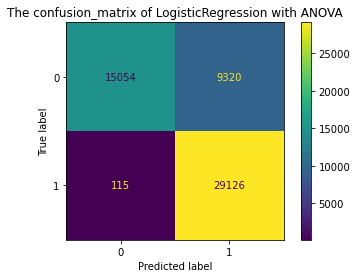

Mean score of 0.995872 with a standard deviation of 0.000129


In [154]:
ModelLR = LogisticRegression(random_state = 42, max_iter=1000, C= 100, penalty= 'l2', solver= 'newton-cg')
fitModel_bestParams(ModelLR, X_LR_AfterFX, y_train, X_testLR_AfterFX, y_test, str("LogisticRegression with " + Df_listLR.idxmax()[0][0]))

the Recall (calss 1) : 0.9996381073011852
the Recall (calss 1) : 0.9996833438885371
the Recall (calss 1) : 0.9995023975391296
the Recall (calss 1) : 0.9996381073011852


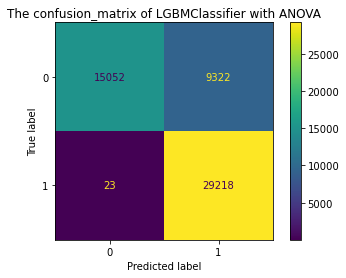

Mean score of 0.999615 with a standard deviation of 0.000068


In [155]:
ModelLGBM = LGBMClassifier(random_state = 42,  min_child_samples= 100, num_leaves = 100, reg_alpha = 0.1)
fitModel_bestParams(ModelLGBM, X_LGBM_AfterFX, y_train, X_testLGBM_AfterFX, y_test, str("LGBMClassifier with " +Df_listLGBM.idxmax()[0][0]))

Using mutual_info on LR & LGBMClassifier

the Recall (calss 1) : 0.9957025242015742


C:\Users\AhmedPro\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\AhmedPro\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


the Recall (calss 1) : 0.9744413281462047
the Recall (calss 1) : 0.996064416900389
the Recall (calss 1) : 0.9958382339636298


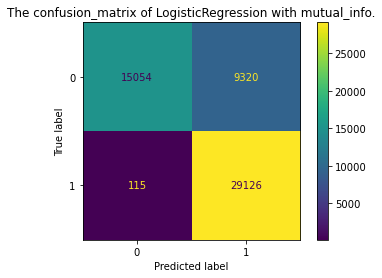

Mean score of 0.990512 with a standard deviation of 0.009279


In [138]:
ModelLR_mutual_info = LogisticRegression(random_state = 42, max_iter=1000, C= 100, penalty= 'l2', solver= 'newton-cg')
fitModel_bestParams(ModelLR_mutual_info, X_mutual_info_scaling, y_trainIMP, X_mutualTest_info_scaling, y_testIMP, "LogisticRegression with mutual_info.")

the Recall (calss 1) : 0.9996833438885371
the Recall (calss 1) : 0.9995928707138334
the Recall (calss 1) : 0.9995023975391296
the Recall (calss 1) : 0.9996381073011852


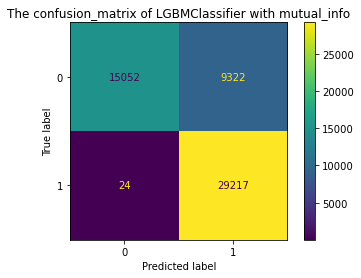

Mean score of 0.999604 with a standard deviation of 0.000067


In [139]:
ModelLGBM_mutual_info = LGBMClassifier(random_state = 42,  min_child_samples= 100, num_leaves = 100, reg_alpha = 0.1)
fitModel_bestParams(ModelLGBM_mutual_info, X_mutual_info_scaling, y_trainIMP, X_mutualTest_info_scaling, y_testIMP, "LGBMClassifier with mutual_info")

## The champion Model (LGBMClassifier With ANOVA)

In [159]:
ModelLGBM = LGBMClassifier(random_state = 42,  min_child_samples= 100, num_leaves = 100, reg_alpha = 0.1)
piplineModelLGBM = make_pipeline(RobustScaler(),SelectKBest(score_func=f_classif, k=Df_listLGBM.idxmax()[0][1]), ModelLGBM)
piplineModelLGBM.fit(X, np.array(y))
joblib.dump(piplineModelLGBM, 'piplineModelLGBM_final.pkl')

['piplineModelLGBM_final.pkl']

# References:
1. https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
2. https://medium.com/@geotourloukis/scikit-learn-pipeline-randomizedsearchcv-ml-model-selection-churn-modeling-dataset-a5bf49fa8dcb